<a href="https://colab.research.google.com/github/juanserrano90/codelatam/blob/main/DataPreparation/modules/add_spikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a draft for the add_spikes module to be added to generate the copies

In [1]:
import sys
from os.path import isfile

import numpy as np
import pandas as pd
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from scipy import stats

# from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# -- Authors: Willow Fox Fortino, Paula Gálvez Molina
# Last Modified: Oct. 20th, 2024

def add_spikes(spectrum, redshift, rng, start=2501.69, end=9993.24):
    """Loosely simulate telluric lines by adding in one-pixel wide spikes to the
       spectra are expected de-redshifted telluric lines.

        Args:
        spectrum (float): Supernova spectrum to be modified.
        redshift (float): Redshift of the supernova of the corresponding spectrum.
        rng (int): Random state seed.
        start (float): Minimum wavelength of the telluric line.
        end (float): Maximum wavelength of the telluric line.

        Returns:
        spiked (array): Spectrum array with spike(s) added."""

    # First decide how many spikes should be added. At most 5 and at minimum one.
    num_spikes = stats.randint.rvs(low=1, high=5, size=1, random_state=rng).item()
    print('num',num_spikes)

    # Next decide the location of the spikes by approximating the first spike at around 760 nm (O2 A-Band) with corresponding redshift.
    # If more than one spike, then the location is given by choosing a random number between 0 and the length of the array containing the spectrum. These other lines intend to simulate artifact.
    tell_loc = 7600 / (redshift + 1)
    # The spectrums are in logarithmic scale, so the index of the location of the spike must be determined by the location of the in the logarithmic array closest in value to the tell_loc.
    log_array = np.logspace(np.log10(start), np.log10(end), num=len(spectrum))    # Create the logarithmically spaced array
    idx = (np.abs(log_array - tell_loc)).argmin()     # Find the index of the element closest to the given value
    spike_loc = stats.randint.rvs(low=0, high=spectrum.size, size=num_spikes, random_state=rng)
    spike_loc[0] = idx

    # Next, we decide if the spike will be an addition or subtraction (i.e., if the telluric line is emission or absorption). 80% of the time, the spike will be in emission (a positive spike) and the rest of the time it will be in absorption.
    spike_dir = stats.binom.rvs(n=1, p=0.80, size=num_spikes, random_state=rng)
    spike_dir[spike_dir == 0] = -1

    # Finally choose the magnitude of the spike. We take the absolute value since we are having the sign of the spike determined by the previous set of code.
    # The standard deviations of the magnitude of the injected spikes will be tied to the standard deviation of the spectrum.
    spike_mag = np.abs(stats.norm.rvs(loc=0, scale=2*spectrum.std(), size=num_spikes, random_state=rng))

    # Construct the array of spikes that is the same shape as the original spectrum.
    spiked = spectrum.copy()
    spiked[spike_loc] = spike_mag * spike_dir

    return spiked

In [12]:
url = "https://github.com/juanserrano90/codelatam/raw/main/Data/data/sn_data.parquet"
df_raw = pd.read_parquet(url)

In [13]:
wavelength = np.array([float(c) for c in df_raw.columns[5:]])

[2501.69 2505.08 2508.48 ... 9966.21 9979.71 9993.24]
1024
num 4


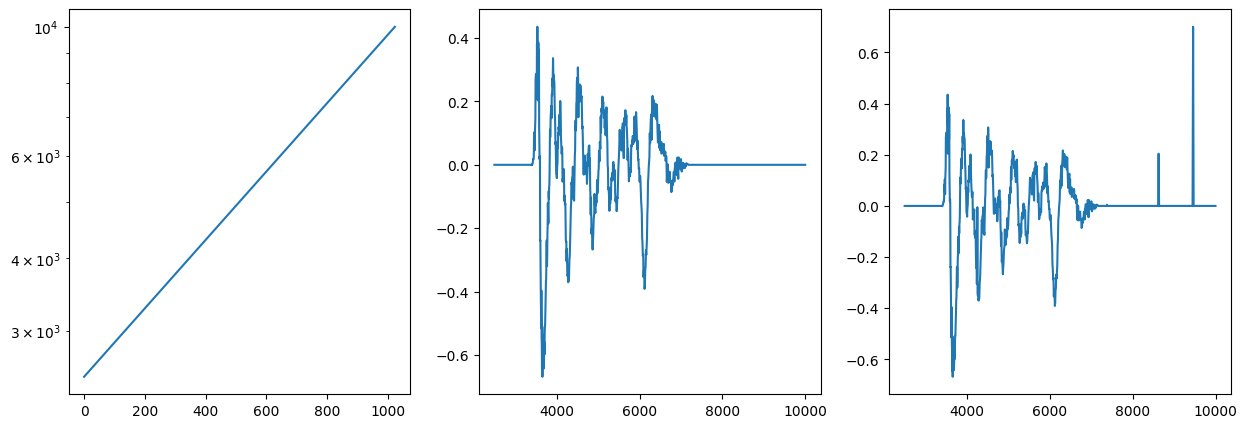

In [42]:
column_names = df_raw.columns.values.tolist()
column_names = np.array(column_names[5:]).astype(float)
print(column_names)
print(len(column_names))
diffs = column_names[1:] - column_names[:-1]
sample = df_raw.loc[(df_raw.index == "sn2008ar") * (df_raw["Spectral Phase"] == -4.6)].iloc[:, 5:].values[0]
sample1 = add_spikes(sample, 0.03, 4532)


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(range(len(column_names)), column_names)
ax[0].set_yscale('log')
ax[1].plot(wavelength, sample)
ax[2].plot(wavelength, sample1)
